# RNN 用于时间序列的分析
前面我们讲到使用 RNN 做简单的图像分类的问题，但是 RNN 并不擅长此类问题，下面我们讲一讲如何将 RNN 用到时间序列的问题上，因为对于时序数据，后面的数据会用到前面的数据，LSTM 的记忆特性非常适合这种场景。

首先我们可以读入数据，这个数据是 10 年飞机月流量，可视化得到下面的效果。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_csv = pd.read_csv('data/airplane_traffic.csv', usecols=[1])

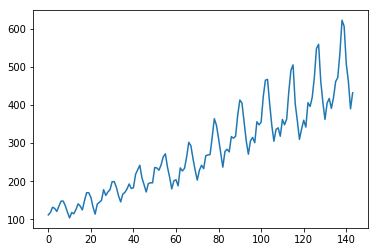

In [3]:
plt.plot(data_csv)

首先我们进行预处理，将数据中 `na` 的数据去掉，然后将数据标准化到 0 ~ 1 之间。

In [4]:
# 数据预处理
data_csv = data_csv.dropna()
dataset = data_csv.values
dataset = dataset.astype('float32')
max_value = np.max(dataset)
min_value = np.min(dataset)
scalar = max_value - min_value
dataset = list(map(lambda x: x / scalar, dataset))

接着我们进行数据集的创建，我们想通过前面几个月的流量来预测当月的流量，比如我们希望通过前两个月的流量来预测当月的流量，我们可以将前两个月的流量当做输入，当月的流量当做输出。同时我们需要将我们的数据集分为训练集和测试集，通过测试集的效果来测试模型的性能，这里我们简单的将前面几年的数据作为训练集，后面两年的数据作为测试集。

In [5]:
def create_dataset(dataset, look_back=2):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [6]:
# 创建好输入输出
data_X, data_Y = create_dataset(dataset)

In [7]:
# 划分训练集和测试集，70% 作为训练集
train_size = int(len(data_X) * 0.7)
test_size = len(data_X) - train_size
train_X = data_X[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X[train_size:]
test_Y = data_Y[train_size:]

In [8]:
train_X = train_X.reshape(-1, 1, 2)
train_Y = train_Y.reshape(-1, 1, 1)
test_X = test_X.reshape(-1, 1, 2)

这里定义好模型，模型的第一部分是一个两层的 RNN，每一步模型接受两个月的输入作为特征，得到一个输出特征。接着通过一个线性层将 RNN 的输出回归到流量的具体数值，这里我们需要用 `view` 来重新排列，因为 `nn.Linear` 不接受三维的输入，所以我们先将前两维合并在一起，然后经过线性层之后再将其分开，最后输出结果。

In [9]:
import tensorflow as tf
import tensorflow.contrib.slim as slim

from utils.layers import lstm

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [10]:
input_ph = tf.placeholder(shape=[None, 1, 2], dtype=tf.float32, name='input')
target_ph = tf.placeholder(shape=[None, 1, 1], dtype=tf.float32, name='target')

In [11]:
def lstm_reg(inputs, num_units, output_size=1, keep_prob=1, num_layers=2, scope='lstm_reg', reuse=None):
    with tf.variable_scope(scope, reuse=reuse):
        net, state = lstm(inputs, num_units, num_layers, 1, keep_prob=keep_prob)

        s, b, n = net.get_shape().as_list()
        net = tf.reshape(net, (-1, num_units))
        net = slim.fully_connected(net, output_size, activation_fn=None, scope='regression')
        net = tf.reshape(net, (-1, b, output_size))

        return net

In [12]:
out = lstm_reg(input_ph, 4)

In [13]:
loss = tf.losses.mean_squared_error(target_ph, out)

In [14]:
opt = tf.train.AdamOptimizer(1e-2)
train_op = opt.minimize(loss)

In [15]:
sess = tf.Session()

In [16]:
sess.run(tf.global_variables_initializer())

In [17]:
for e in range(1000):
    feed_dict = {input_ph: train_X, target_ph: train_Y}
    sess.run(train_op, feed_dict=feed_dict)
    if (e + 1) % 100 == 0:
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, sess.run(loss, feed_dict=feed_dict)))

Epoch: 100, Loss: 0.00395
Epoch: 200, Loss: 0.00369
Epoch: 300, Loss: 0.00344
Epoch: 400, Loss: 0.00300
Epoch: 500, Loss: 0.00188
Epoch: 600, Loss: 0.00132
Epoch: 700, Loss: 0.00122
Epoch: 800, Loss: 0.00117
Epoch: 900, Loss: 0.00113
Epoch: 1000, Loss: 0.00109


In [18]:
data_X = data_X.reshape((-1, 1, 2))

In [19]:
pred_test = sess.run(out, feed_dict={input_ph: data_X})
pred_test = pred_test.flatten()

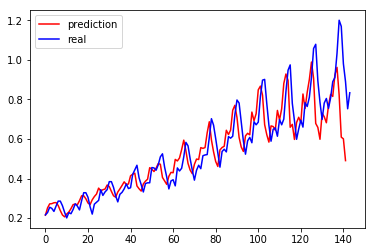

In [20]:
# 画出实际结果和预测的结果
plt.plot(pred_test, 'r', label='prediction')
plt.plot(dataset, 'b', label='real')
plt.legend(loc='best')

这里蓝色的是真实的数据集，红色的是预测的结果，我们能够看到，使用 lstm 能够得到比较相近的结果，预测的趋势也与真实的数据集是相同的，因为其能够记忆之前的信息，而单纯的使用线性回归并不能得到较好的结果，从这个例子也说明了 RNN 对于序列有着非常好的性能。